### Feature Engineering y Modelado Predictivo de Permisos de Circulación

Este notebook toma el dataset limpio y estandarizado del paso anterior y lo utiliza para un problema de Machine Learning. El objetivo es:

1. Ingeniería de Características: Crear nuevas variables que puedan mejorar el rendimiento del modelo.

2. Preparación de Datos: Preparar los datos para el entrenamiento de un modelo predictivo.

3. Modelado: Entrenar un modelo de clasificación simple para predecir el estado de un permiso (Activo o Inactivo) basándose en sus características.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar el dataset limpio y procesado del paso anterior
df_clean = pd.read_csv('data/processed/permisos_circulacion_limpio.csv')

# Inspección inicial del dataset limpio
print("--- Información del dataset limpio ---")
df_clean.info()
print("\n--- Primeras 5 filas del dataset limpio ---")
print(df_clean.head())

--- Información del dataset limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_permiso        5000 non-null   int64  
 1   tipo_vehiculo     5000 non-null   object 
 2   fecha_emision     5000 non-null   object 
 3   duracion_dias     5000 non-null   float64
 4   zona_circulacion  5000 non-null   object 
 5   estado            5000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 234.5+ KB

--- Primeras 5 filas del dataset limpio ---
   id_permiso tipo_vehiculo               fecha_emision  duracion_dias  \
0           1     Bicicleta  2025-01-23 01:15:34.271018           27.0   
1           2     Furgoneta  2024-11-05 01:15:34.271043           15.0   
2           3     Furgoneta  2025-03-14 01:15:34.271049           23.0   
3           4        Camion  2024-09-03 01:15:34.271052           16.0   


### 1. Ingeniería de Características (Feature Engineering)
Vamos a crear nuevas variables a partir de las existentes para darle más información al modelo. Transformaremos las fechas en variables de tiempo y usaremos 'one-hot encoding' para las variables categóricas.

In [2]:
# Convertir la columna de fecha a formato datetime
df_clean['fecha_emision'] = pd.to_datetime(df_clean['fecha_emision'], errors='coerce')

# Eliminar las filas con fechas inválidas que no pudieron ser convertidas
df_clean.dropna(subset=['fecha_emision'], inplace=True)

# Crear nuevas variables de tiempo
df_clean['dia_semana'] = df_clean['fecha_emision'].dt.day_name()
df_clean['mes'] = df_clean['fecha_emision'].dt.month
df_clean['dia_del_mes'] = df_clean['fecha_emision'].dt.day

# Calcular una fecha de expiración para un posible problema de clasificación
df_clean['fecha_expiracion'] = df_clean['fecha_emision'] + pd.to_timedelta(df_clean['duracion_dias'], unit='D')

# Convertir variables categóricas en variables 'dummy' (one-hot encoding)
df_model = pd.get_dummies(df_clean, columns=['tipo_vehiculo', 'zona_circulacion', 'dia_semana'])

# Eliminar la columna de fecha_emision ya que hemos extraído la información relevante
df_model.drop(columns=['fecha_emision', 'fecha_expiracion'], inplace=True)

# Verificación de la estructura del nuevo DataFrame
print("--- Estructura del DataFrame después de la ingeniería de características ---")
print(df_model.head())
print("\n--- Columnas finales para el modelo ---")
print(df_model.columns)

--- Estructura del DataFrame después de la ingeniería de características ---
   id_permiso  duracion_dias    estado  mes  dia_del_mes  \
0           1           27.0  Inactivo    1           23   
1           2           15.0    Activo   11            5   
2           3           23.0    Activo    3           14   
3           4           16.0  Inactivo    9            3   
4           5            8.0    Activo   11            7   

   tipo_vehiculo_Bicicleta  tipo_vehiculo_Camion  tipo_vehiculo_Coche  \
0                     True                 False                False   
1                    False                 False                False   
2                    False                 False                False   
3                    False                  True                False   
4                    False                  True                False   

   tipo_vehiculo_Furgoneta  tipo_vehiculo_Monopatin  ...  \
0                    False                    False  ...   
1  

### 2. Preparación de los Datos para el Modelado

Dividiremos nuestro dataset en dos partes: un conjunto de entrenamiento (train) y un conjunto de prueba (test). Esto es fundamental para evaluar el rendimiento del modelo de forma objetiva.

1. Características (X): Las variables que usaremos para predecir.

2. Variable Objetivo (y): La variable que queremos predecir, en este caso, el estado del permiso.

In [3]:
# Definir las características (X) y la variable objetivo (y)
X = df_model.drop(columns=['estado'])
y = df_model['estado']

# Convertir la variable objetivo a valores numéricos (0 y 1)
y = y.map({'Activo': 1, 'Inactivo': 0})

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Tamaño de los conjuntos de datos ---")
print(f"Conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Conjunto de prueba (X_test): {X_test.shape}")

--- Tamaño de los conjuntos de datos ---
Conjunto de entrenamiento (X_train): (3960, 22)
Conjunto de prueba (X_test): (990, 22)


### 3. Entrenamiento y Evaluación del Modelo

Utilizaremos un modelo de clasificación simple y robusto como RandomForestClassifier. Luego evaluaremos su rendimiento en el conjunto de prueba para ver qué tan bien predice el estado del permiso.

--- Evaluación del modelo RandomForest ---
Precisión (Accuracy): 0.7859

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

    Inactivo       0.21      0.01      0.03       204
      Activo       0.79      0.99      0.88       786

    accuracy                           0.79       990
   macro avg       0.50      0.50      0.45       990
weighted avg       0.67      0.79      0.70       990



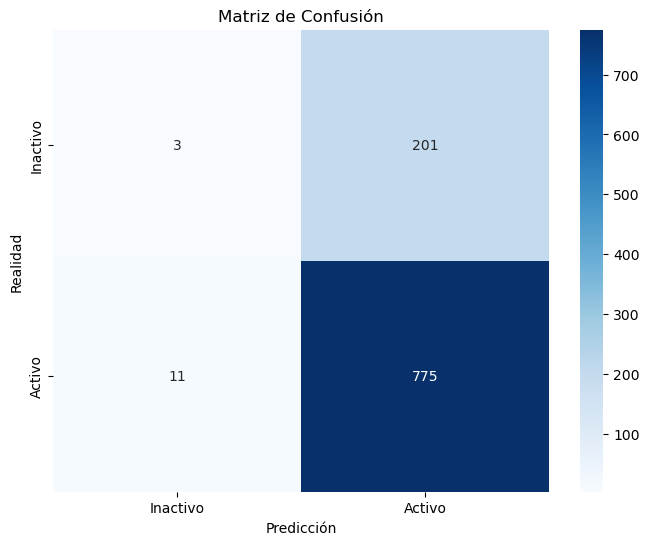

In [4]:
# Inicializar y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Inactivo', 'Activo'])
conf_matrix = confusion_matrix(y_test, y_pred)

print("--- Evaluación del modelo RandomForest ---")
print(f"Precisión (Accuracy): {accuracy:.4f}")
print("\n--- Reporte de Clasificación ---")
print(report)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactivo', 'Activo'], yticklabels=['Inactivo', 'Activo'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

### 4. Resolviendo el Problema de Desbalance de Clases

Como se observó en la sección anterior, el modelo mostró un rendimiento deficiente para la clase minoritaria ("Inactivo") debido al desbalance de clases. En esta sección, aplicaremos dos técnicas comunes para mitigar este problema y reevaluaremos el modelo.

Técnicas a utilizar:

1. Ponderación de Clases (class_weight): Asigna un peso mayor a los errores de la clase minoritaria durante el entrenamiento.

2. Sobremuestreo (SMOTE): Crea instancias sintéticas de la clase minoritaria para igualar el número de registros en ambos grupos.

In [5]:
from imblearn.over_sampling import SMOTE

def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Inactivo', 'Activo'])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"--- Evaluación del modelo ({title}) ---")
    print(f"Precisión (Accuracy): {accuracy:.4f}")
    print("\n--- Reporte de Clasificación ---")
    print(report)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactivo', 'Activo'], yticklabels=['Inactivo', 'Activo'])
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title(f'Matriz de Confusión ({title})')
    plt.show()

### Método 1: Modelo con Ponderación de Clases (class_weight)

Añadimos el parámetro class_weight='balanced' al modelo para que aprenda a priorizar la clase minoritaria.

--- Evaluación del modelo (Modelo con Ponderación de Clases) ---
Precisión (Accuracy): 0.7899

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

    Inactivo       0.17      0.00      0.01       204
      Activo       0.79      0.99      0.88       786

    accuracy                           0.79       990
   macro avg       0.48      0.50      0.45       990
weighted avg       0.66      0.79      0.70       990



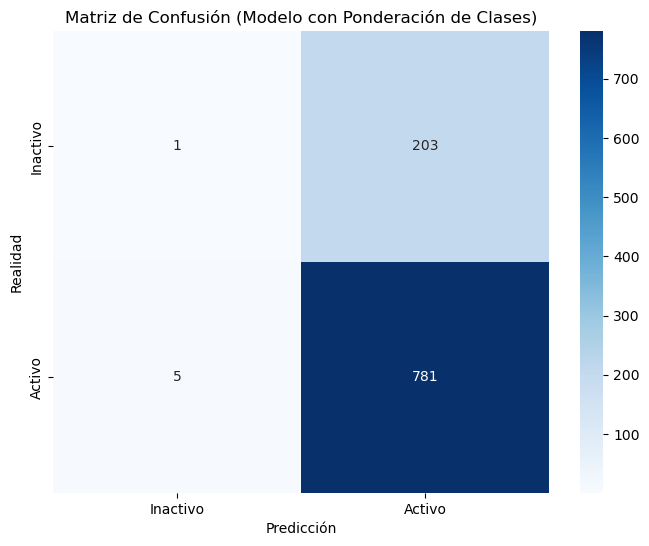

In [6]:
# Entrenar el modelo con ponderación de clases
model_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_weighted.fit(X_train, y_train)

# Evaluar el modelo ponderado
evaluate_model(model_weighted, X_test, y_test, 'Modelo con Ponderación de Clases')

### Método 2: Sobremuestreo con SMOTE
SMOTE es una técnica que genera nuevos ejemplos sintéticos de la clase minoritaria en el conjunto de entrenamiento para balancear las proporciones.

--- Resumen de la distribución de clases después de SMOTE ---
Clases en el conjunto de entrenamiento original: estado
1    3098
0     862
Name: count, dtype: int64
Clases en el conjunto de entrenamiento con SMOTE: estado
0    3098
1    3098
Name: count, dtype: int64
--- Evaluación del modelo (Modelo con SMOTE) ---
Precisión (Accuracy): 0.7707

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

    Inactivo       0.26      0.06      0.10       204
      Activo       0.80      0.96      0.87       786

    accuracy                           0.77       990
   macro avg       0.53      0.51      0.48       990
weighted avg       0.68      0.77      0.71       990



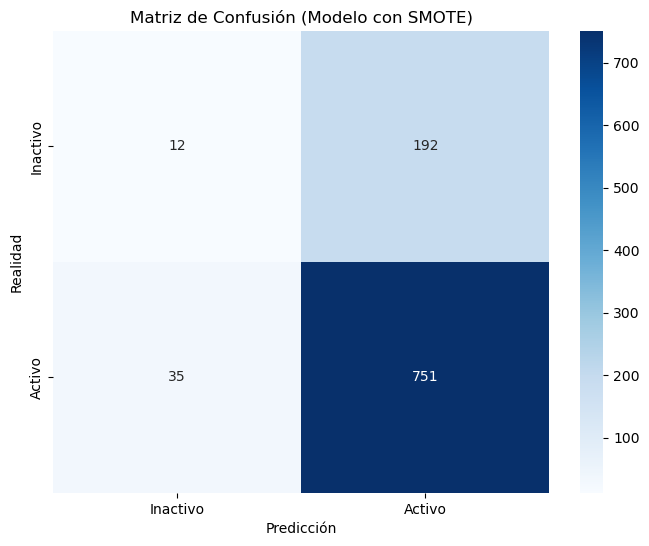

In [7]:
# Aplicar SMOTE solo al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("--- Resumen de la distribución de clases después de SMOTE ---")
print(f"Clases en el conjunto de entrenamiento original: {y_train.value_counts()}")
print(f"Clases en el conjunto de entrenamiento con SMOTE: {y_train_res.value_counts()}")

# Entrenar un nuevo modelo (sin ponderación, ya que los datos están balanceados)
model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_res, y_train_res)

# Evaluar el modelo con datos balanceados por SMOTE
evaluate_model(model_smote, X_test, y_test, 'Modelo con SMOTE')